In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
import evals.teaching_evals as evals
import utils.gen_triplets as gen
from utils.tste import tste as tste

sns.set_theme()
def get_ci(samples, confidence=0.95):  return stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)


SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
color_list = ['k','y','m','g','c','r','b','lime']
marker_list = ['o','s','^','D','x','p','*','8']
linestyle_list = ['solid','dashed','dashdot','dotted','solid','dashed','dashdot','dotted']

In [2]:
dataset = "bird"
transform = transforms.bird_transform()

In [3]:
train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
x_train = np.array([x[0].numpy() for x in train])
x_test = np.array([x[0].numpy() for x in test])
y_train = np.array([x[1] for x in train])
y_test = np.array([x[1] for x in test])

lpips_path = f"data/dist/lpips/{dataset}"
lpips_train = pickle.load(open(f"{lpips_path}/lpips.alex.train.pkl","rb"))
lpips_valid = pickle.load(open(f"{lpips_path}/lpips.alex.train_valid.pkl","rb"))
lpips_test = pickle.load(open(f"{lpips_path}/lpips.alex.train_test.pkl","rb"))

## concat-embed experiments

In [4]:
def rand_score(dist_M, m, X, y_train, y_test, n_trials=1000):
    random_scores = np.array([evals.eval_KNN(dist_M, algs.random(X, m), y_train, y_test) for _ in range(n_trials)])
    random_ci = get_ci(random_scores)
    random_score = random_scores.mean()
    return random_score, random_ci

def full_rand_score(m_range, dist_M, X, y_train, y_test):
    full_score = evals.eval_KNN(dist_M, np.arange(len(y_train)), y_train, y_test, k=1)
    random_scores = []
    random_cis = []
    for m in m_range:
        random_score, random_ci = rand_score(dist_M, m, X, y_train, y_test)
        random_scores.append(random_score)
        random_cis.append(random_ci)
    random_scores = np.array(random_scores)
    random_cis = np.array(random_cis)
    return full_score, random_scores

In [5]:
train_triplets = pickle.load(open("data/triplets/bm/prolific/train_triplets_filtered.pkl","rb"))

In [6]:
train_triplets = pickle.load(open(f"data/triplets/{dataset}/lpips/train_triplets.pkl","rb"))
train_triplets = gen.filter_train_triplets(train_triplets, y_train)

In [7]:
z = tste(np.array(train_triplets), no_dims=50, max_iter=100)
concat_z, idx = evals.concat_embeds(z, y_train)

0.8863756613756614


In [8]:
m_range = np.arange(4, 21, 2)
dist_M = lpips_test
alg_name = "protogreedy"
alg = algs.protogreedy
lw = 4

In [9]:
full_score, random_scores = full_rand_score(m_range, dist_M, z, y_train, y_test)
nn_scores, cv_scores, el_scores, ce_scores, nn_half_scores = [], [], [], [], []

for m in m_range:
    S_concat = alg(concat_z, m//2)
    S_pairs = idx[S_concat]
    S_single = alg(z, m)
    nn_scores.append(evals.eval_KNN(dist_M, S_single, y_train, y_test))
    cv_scores.append(evals.eval_CV(dist_M, S_pairs, y_train, y_test))
    el_scores.append(evals.eval_EL(dist_M, S_single, y_train, y_test))
    ce_scores.append(evals.eval_CVEL(dist_M, S_pairs, y_train, y_test))

for m in m_range//2:
    S_single = alg(z, m)
    nn_half_scores.append(evals.eval_KNN(dist_M, S_single, y_train, y_test))

Text(0.5, 1.0, 'bird_protogreedy')

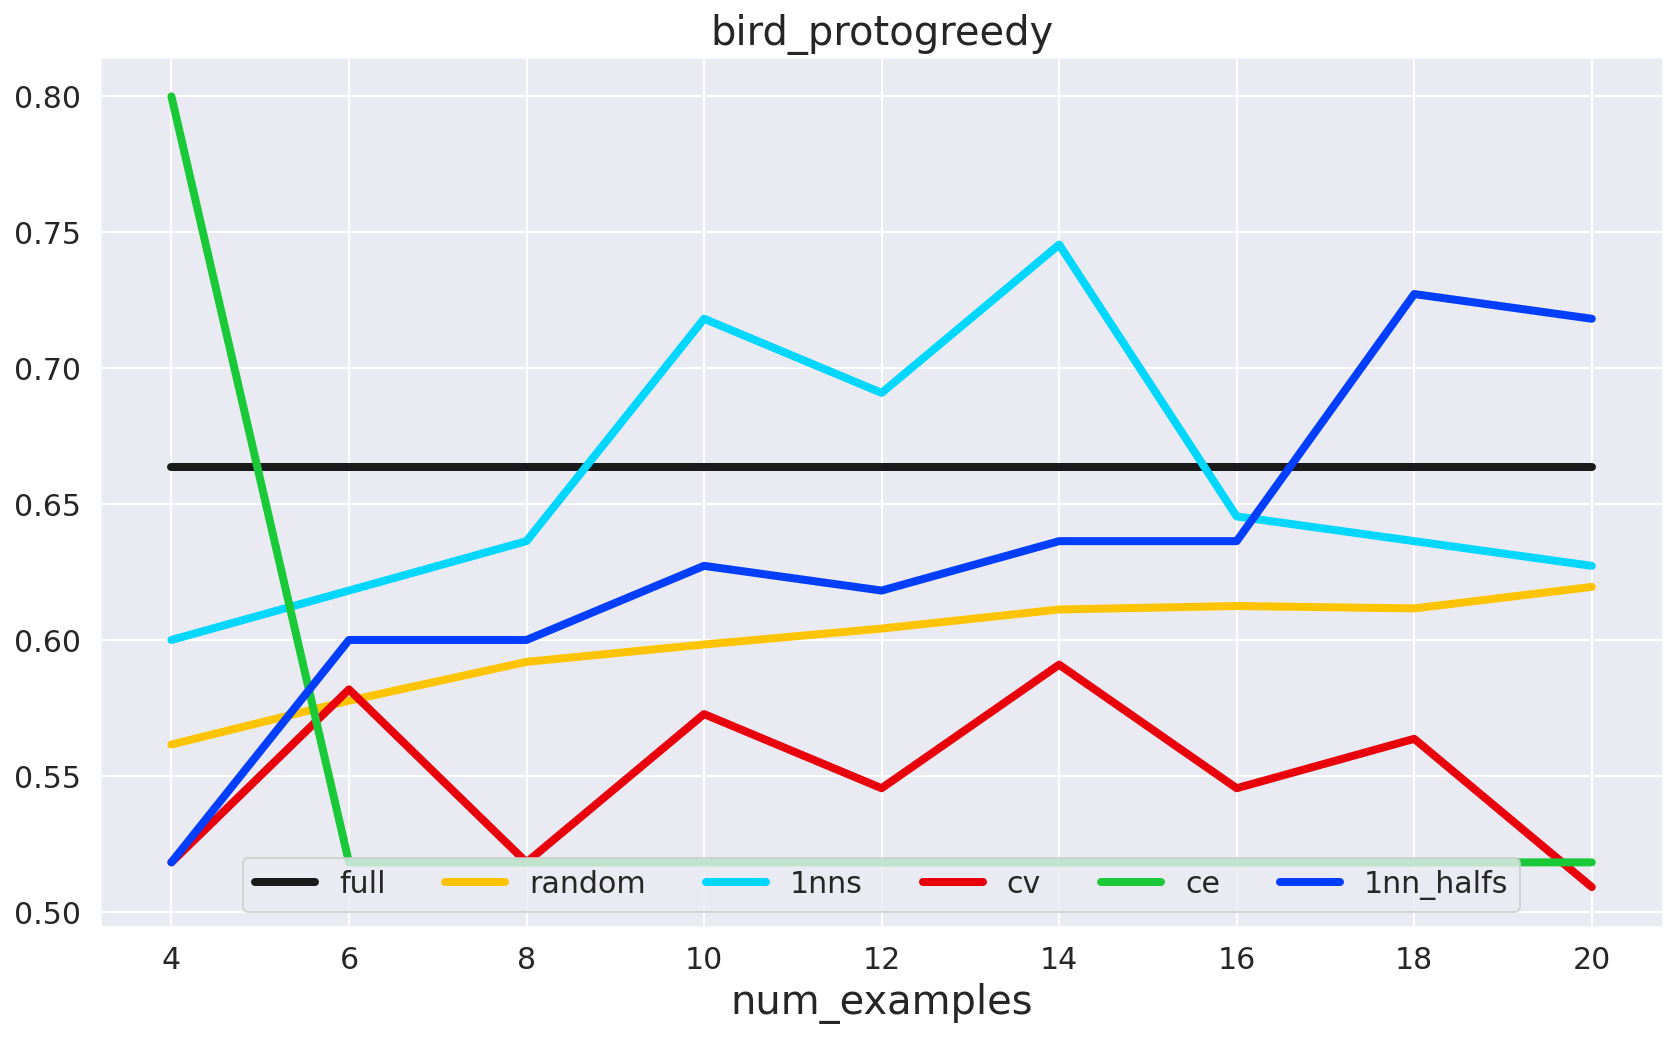

In [10]:
data = {"full_score": [full_score]*len(m_range), 
        "random_score": random_scores,
        "1nn_scores": nn_scores,
        "cv_score": cv_scores,
        # "el_score": el_scores,
        "ce_score": ce_scores,
        "1nn_half_scores": nn_half_scores,
        }
legend = [score.replace("_score","") for score in data]
palette = {"full_score": "k", 
        "random_score": "y",
        "1nn_scores": "c",
        "cv_score": "r",
        # "el_score": el_scores,
        "ce_score": "g",
        "1nn_half_scores": "b",}

sns.set_color_codes("bright")
plt.figure(figsize=(14,8))
for score in data.keys():
        _ = plt.plot(m_range, data[score], lw=lw, color=palette[score])

plt.xticks(m_range)
plt.xlabel("num_examples")
# plt.ylim(0.2, 1)

plt.legend(legend, loc="lower center", ncol=len(data))
plt.title(f"{dataset}_{alg_name}")

In [11]:
sdadasdasdasd

NameError: name 'sdadasdasdasd' is not defined

In [ ]:
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))
x = 1/lpips_test

In [ ]:
S1, S2 = algs.kmedoids_contrastive(X, y_train, m)
pairs = algs.group_max(X, S1,S2)
evals.get_CV_score(lpips_alex, pairs, y_train, y_test)

In [ ]:
evals.get_knn_score_lpips(lpips_alex, np.array(pairs).flatten(), y_train, y_test)

In [ ]:
x_pixel = np.array([x.flatten() for x in x_train])
x_50 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb50.pkl","rb"))
x_512 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb512.pkl","rb"))

In [ ]:
m_range = np.arange(3,21)
lw = 4

In [ ]:
def get_full_random(m_range, lpips, X, y_train, y_test):
    full_score = evals.get_knn_score_lpips(lpips, np.arange(len(y_train)), y_train, y_test, k=1)
    random_scores = []
    random_cis = []
    for m in m_range:
        random_score, random_ci = get_random_score(lpips, m, X, y_train, y_test)
        random_scores.append(random_score)
        random_cis.append(random_ci)
    random_scores = np.array(random_scores)
    random_cis = np.array(random_cis)
    return full_score, random_scores
    
def get_pdash_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.protodash(X, m), y_train, y_test, k=1) for m in m_range])

def get_k_medoids_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.k_medoids(X, m), y_train, y_test, k=1) for m in m_range])

In [ ]:
def get_df(X):
    agent_df = {}
    for i, (lpips, title) in enumerate([(lpips_alex, "lpips_alex")]):#, (lpips_vgg, "lpips_vgg"), (lpips_squeeze,"lpips_squeeze")]):
        full_score, random_scores = get_full_random(m_range, lpips, X, y_train, y_test)
        k_medoids_scores = get_k_medoids_scores(m_range, lpips, X, y_train, y_test)
        pdash_scores = get_pdash_scores(m_range, lpips, X, y_train, y_test)

        data = {"full_score": [full_score]*len(m_range), 
                "random_score": random_scores,
                "k_medoids_scores": k_medoids_scores,
                "pdash_scores": pdash_scores}
        df = pd.DataFrame(data)
        df = df.set_index(m_range)
        agent_df[title] = df
        return df
        
    return agent_df

In [ ]:
titles = ["image pixel", "resn_d=512", "resn_d=50"]
df_pixel = get_df(x_pixel)
df_512 = get_df(x_512)
df_50 = get_df(x_50)

In [ ]:
sns.set_theme()
plt.rc('legend', fontsize=15)    # legend fontsize

fig, ax = plt.subplots(1,3 , figsize=(8*3, 6), sharey=True, sharex=True)
for i, (df, title) in enumerate(zip([df_pixel, df_512, df_50], titles)):
    sns.lineplot(data=df, lw=4, ax=ax[i], legend=None)
    ax[i].set_xlabel("num_examples")
    ax[i].set_title(title, fontsize=20)
plt.xticks(m_range)
plt.ylim([0.2, 1])
ax[2].legend(["full", "random", "k_medoids", "pdash"])
fig.suptitle(f"lpips_knn: {dataset}", y=1)